<a href="https://colab.research.google.com/github/sulaimanbehzad/Classifying-Images/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiers
The purpose of this project is to train two classifiers:
1. Captions classifier
2. Image classifier

In [134]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import utils
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import np_utils
from keras import regularizers

## Part 2: Image Classifier

setting-up the parameters for image loader

In [135]:
img_width, img_height = 224, 224
path_train_images = r'/content/drive/MyDrive/dataset/train/images'   
path_test_images =  r'/content/drive/MyDrive/dataset/test/images'
path_dataset = r'/content/drive/MyDrive/dataset'
nb_train_samples = 532
nb_validation_samples = 380
epochs = 50
batch_size = 32

### Data Acquisition 
im_generator was repurposed to apply some mandatory disnormalities in images to make up for the small dataset, but it had a bad imapct on training

In [136]:
# im_generator = ImageDataGenerator(
# 	rotation_range=30,
# 	zoom_range=0.15,
# 	width_shift_range=0.2,
# 	height_shift_range=0.2,
# 	shear_range=0.15,
# 	horizontal_flip=True,
# 	fill_mode="nearest")
im_generator = ImageDataGenerator(
    # featurewise_center=True, samplewise_center=True,
    # rescale = 1/255.,
    fill_mode="nearest"
)

In [137]:
train_df = im_generator.flow_from_directory(
  path_train_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )



Found 532 images belonging to 19 classes.


In [138]:
val_df = im_generator.flow_from_directory(
  path_test_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 380 images belonging to 19 classes.


In [139]:
tags = train_df.labels
print(f'tags are: {tags} \n and length of tags is: {len(tags)}')

tags are: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 1

If we try to put a data augmentor model before the pretrained model it will affect the performance of pretrained model badly since the pretrained model expects the input data to be raw (unprocessed)

In [140]:
# data_augmentation = keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#   ]
# )


### Pretrained model acqusition
For feature extraction purposes we set include_top to false, it's whethere to include the fully connected layer at top_of the network

In [141]:
model_resnet = ResNet50(weights='imagenet', include_top=False, 
                              input_shape=(img_width, img_height, 3))
model_resnet.trainable = False
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [142]:
model_efficient = EfficientNetB2(weights='imagenet', include_top=False, 
                              input_shape=(img_width, img_height, 3))
model_efficient.trainable = False
model_efficient.summary()

31793152/31790344 [==============================] - 1s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]            
____________________

### Feature Extraction: 
In this stage we use the pretrained model as a feature extractor  
* X_train_e is the prediction/features of the training data   
* X_test_e is the prediction/features of the test/validation data

In [143]:
X_train_e = model_efficient.predict(train_df, batch_size=batch_size)
# X_train_r = model_resnet.predict(train_df, batch_size=batch_size)

In [144]:
X_test_e = model_efficient.predict(val_df, batch_size=batch_size)
# X_test_r = model_resnet.predict(val_df, batch_size=batch_size)

In [145]:
# X_train.to_csv(r'/content/drive/MyDrive/dataset/train/X_train.csv', index=False)
# X_test.to_csv(r'/content/drive/MyDrive/dataset/test/X_test.csv', index=False )

In [146]:
# X_train = pd.read_csv('/content/drive/MyDrive/dataset/train/X_train.csv')
# X_test = pd.read_csv('/content/drive/MyDrive/dataset/test/X_test.csv')
# X_test

In [147]:
# plt.figure(figsize=(15, 10))
# for im, lbl in train_df.take(1):
#   for i in range(4):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(im[i].numpy().astype("uint8"))
#     plt.title(tags[lbl[i]])
#     plt.axis("off")


In [148]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_df = validation_df.cache().prefetch(buffer_size=AUTOTUNE)


In [149]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [150]:
# normalized_df = train_df.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_df))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


here we change the lables to one-hot representation

In [151]:
y_train = utils.to_categorical(train_df.labels)
y_test = utils.to_categorical(val_df.labels)

In [152]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### The actual model
the following model was optimised on accuracy level to have the number of layers, dropout rate, regularization hyperparameter, optimizer and number of # number units in each layer such as below: 

In [153]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=1e-3, momentum=0.9, decay=1e-3 / 25)
reg_hyp = 0
model = Sequential([
  layers.Flatten(),
  BatchNormalization(),
  layers.Dense(512, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.6),
  BatchNormalization(),
  layers.Dense(256, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(128, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(64, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(19, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

we will train the model in two steps

In [154]:
history = model.fit(
    X_train_e,
    y_train,
    epochs=25,
    shuffle=True,
    validation_data=(X_test_e, y_test),
    batch_size=128 
)


Epoch 1/25
5/5 [==============================] - 9s 1s/step - loss: 3.3921 - accuracy: 0.0793 - val_loss: 2.5843 - val_accuracy: 0.4658
Epoch 2/25
5/5 [==============================] - 6s 1s/step - loss: 2.7336 - accuracy: 0.1899 - val_loss: 1.8724 - val_accuracy: 0.5605
Epoch 3/25
5/5 [==============================] - 6s 1s/step - loss: 2.4202 - accuracy: 0.2534 - val_loss: 1.7298 - val_accuracy: 0.5763
Epoch 4/25
5/5 [==============================] - 6s 1s/step - loss: 2.2569 - accuracy: 0.3038 - val_loss: 1.6118 - val_accuracy: 0.6132
Epoch 5/25
5/5 [==============================] - 6s 1s/step - loss: 2.1100 - accuracy: 0.3405 - val_loss: 1.5296 - val_accuracy: 0.6184
Epoch 6/25
5/5 [==============================] - 6s 1s/step - loss: 1.9986 - accuracy: 0.4099 - val_loss: 1.4362 - val_accuracy: 0.6211
Epoch 7/25
5/5 [==============================] - 6s 1s/step - loss: 1.7616 - accuracy: 0.4808 - val_loss: 1.3878 - val_accuracy: 0.6395
Epoch 8/25
5/5 [=========================

In [155]:
history2 = model.fit(X_train_e,
                     y_train,
                     epochs=50,
                     shuffle=True,
                     validation_data=(X_test_e, y_test),
                     batch_size=128, 
                     initial_epoch=history.epoch[-1])

Epoch 25/50
5/5 [==============================] - 6s 1s/step - loss: 0.5145 - accuracy: 0.8947 - val_loss: 1.2924 - val_accuracy: 0.6868
Epoch 26/50
5/5 [==============================] - 6s 1s/step - loss: 0.5217 - accuracy: 0.9192 - val_loss: 1.2902 - val_accuracy: 0.6947
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 0.4707 - accuracy: 0.9305 - val_loss: 1.2568 - val_accuracy: 0.6789
Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 0.4806 - accuracy: 0.9098 - val_loss: 1.2543 - val_accuracy: 0.6842
Epoch 29/50
5/5 [==============================] - 5s 1s/step - loss: 0.4372 - accuracy: 0.9323 - val_loss: 1.2349 - val_accuracy: 0.6895
Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 0.4370 - accuracy: 0.9398 - val_loss: 1.2629 - val_accuracy: 0.6868
Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 0.3999 - accuracy: 0.9361 - val_loss: 1.2698 - val_accuracy: 0.6868
Epoch 32/50
5/5 [=================

in the second step the model tends to overfit we can control this by setting the regularization parameter, but it will keep the model at a lower accuracy  
to rephrase, the model will not generalise as welll

In [156]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 68992)             0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 68992)             275968    
_________________________________________________________________
dense_68 (Dense)             (None, 512)               35324416  
_________________________________________________________________
dropout_56 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 512)               2048      
_________________________________________________________________
dense_69 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)             

In [157]:
score = model.evaluate(X_test_e, y_test, batch_size=batch_size, verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')

12/12 [==============================] - 1s 63ms/step - loss: 1.2913 - accuracy: 0.6816
Test loss:1.2913223505020142
Test accuracy:0.6815789341926575


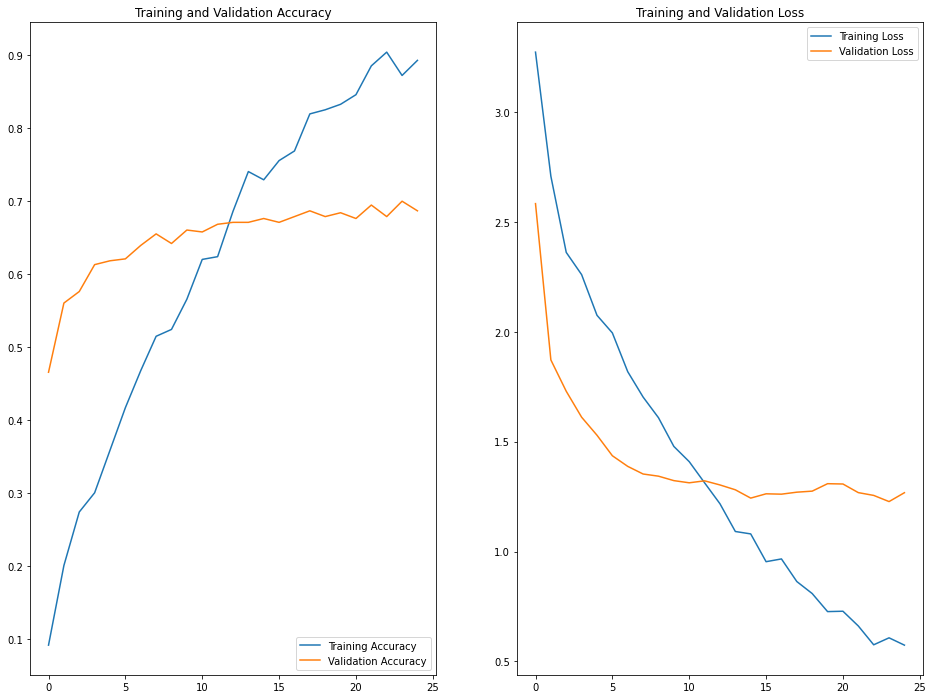

In [158]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs_range = range(25)


plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We tried the models below:  
1. VGG16
2. InceptionV3
3. InceptionResnetV2
4. ResNet50
5. Resnet50v2
6. EfficientNetB0 - B5   

the highest accuracy was obtained from EfficientNetB2 and ResNet50, while the first one is simpler in comparison its performance in this context proved to be better.



